In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

In [2]:

df = pd.read_csv("../data/raw_analyst_ratings.csv", header=None)   

df.columns = ['number', 'headline', 'url', 'publisher', 'date', 'stock']

df['headline'] = df['headline'].astype(str).str.strip()
df['url'] = df['url'].astype(str).str.strip()
df['publisher'] = df['publisher'].astype(str).str.strip().str.title()
df['stock'] = df['stock'].astype(str).str.strip().str.upper()

# Convert 'date' to datetime
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Ensure 'number' is numeric
df['number'] = pd.to_numeric(df['number'], errors='coerce')

# Drop rows with missing values (optional: you can also choose to fill them)
df = df.dropna()

# Drop duplicates
df = df.drop_duplicates()

df.to_csv("../data/cleaned_analyst_ratings.csv", index=False)

# Final check
print(df.info())
print(df.head())

C:\Users\PC\AppData\Local\Temp\ipykernel_17020\4192672468.py:11: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['date'] = pd.to_datetime(df['date'], errors='coerce')
C:\Users\PC\AppData\Local\Temp\ipykernel_17020\4192672468.py:11: FutureWarning: In a future version of pandas, parsing datetimes with mixed time zones will raise an error unless `utc=True`. Please specify `utc=True` to opt in to the new behaviour and silence this warning. To create a `Series` with mixed offsets and `object` dtype, please use `apply` and `datetime.datetime.strptime`
  df['date'] = pd.to_datetime(df['date'], errors='coerce')


<class 'pandas.core.frame.DataFrame'>
Index: 1407328 entries, 1 to 1407328
Data columns (total 6 columns):
 #   Column     Non-Null Count    Dtype  
---  ------     --------------    -----  
 0   number     1407328 non-null  float64
 1   headline   1407328 non-null  object 
 2   url        1407328 non-null  object 
 3   publisher  1407328 non-null  object 
 4   date       1407328 non-null  object 
 5   stock      1407328 non-null  object 
dtypes: float64(1), object(5)
memory usage: 75.2+ MB
None
   number                                           headline  \
1     0.0            Stocks That Hit 52-Week Highs On Friday   
2     1.0         Stocks That Hit 52-Week Highs On Wednesday   
3     2.0                      71 Biggest Movers From Friday   
4     3.0       46 Stocks Moving In Friday's Mid-Day Session   
5     4.0  B of A Securities Maintains Neutral on Agilent...   

                                                 url          publisher  \
1  https://www.benzinga.com/news/20/06/

In [20]:
#headline length
df['headline_length'] = df['headline'].str.len()
print(df['headline_length'].describe())

count    1.407328e+06
mean     7.312051e+01
std      4.073531e+01
min      3.000000e+00
25%      4.700000e+01
50%      6.400000e+01
75%      8.700000e+01
max      5.120000e+02
Name: headline_length, dtype: float64


In [30]:
#top 10 publishers
publisher_counts = df['publisher'].value_counts()
top_publishers = publisher_counts.head(10)
print(top_publishers)  # Top 10 publishers


publisher
Paul Quintaro        228373
Lisa Levin           186979
Benzinga Newsdesk    150484
Charles Gross         96732
Monica Gerson         82380
Eddie Staley          57254
Hal Lindon            49047
Etf Professor         28489
Juan Lopez            28438
Benzinga Staff        28114
Name: count, dtype: int64


<Axes: title={'center': 'Articles Over Time'}, xlabel='date'>

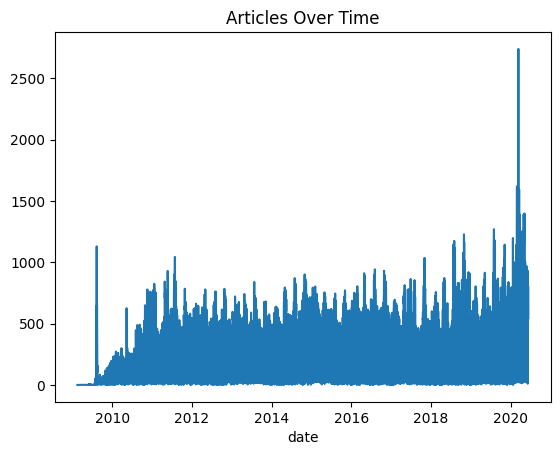

In [22]:
df['date'] = pd.to_datetime(df['date'], utc=True)
daily_articles = df.groupby(df['date'].dt.date).size()
daily_articles.plot(kind='line', title='Articles Over Time')


In [25]:
#Text Analysis(Topic Modeling)
keywords = ['fda approval', 'price target', 'earnings report', 'ipo', 'merger', 'dividend', 'layoffs', 'quarter results', 'buyback', 'revenue growth']

for keyword in keywords:
    matches = df[df['headline'].str.contains(keyword.replace(" ", ""), case=False)]
    print(f"\n--- {keyword.upper()} ---")
    print(matches['headline'].head(5).to_string(index=False))



--- FDA APPROVAL ---
Series([], )

--- PRICE TARGET ---
Series([], )

--- EARNINGS REPORT ---
Series([], )

--- IPO ---
             Agilent Tech in Pact with Liposcience
Two Life Science Companies Manage to Pry Open I...
New "Transformer(TM)" for iPod/iPhone and "Tran...
The Week Ahead: Netflix Earnings, Comic-Con, 'I...
The Market In 5 Minutes: Chipotle CEO Search, M...

--- MERGER ---
RMR Funds' Revised Merger Documents Filed With SEC
BluMont Capital Corporation Completes Fund Mergers
                 FTC Approves of AA and RTI Merger
Is CA Considering Consensual Acquisition-Merger...
UPDATE: Credit Suisse Reiterates On Advance Aut...

--- DIVIDEND ---
Agilent Raises Qtr. Dividend From $0.164 To $0....
Agilent Raises Qtr. Dividend From $0.13/Share T...
Top 4 NYSE Stocks In The Medical Laboratories &...
Agilent Technologies Reports New Buyback Plan, ...
Agilent Authorizes $500M Buyback, Raises Qtr. D...

--- LAYOFFS ---
UPDATE: American Says Aid Package With Treasury...
Another Auto

In [26]:
#spikes with market events
# Ensure your date column is datetime
df['date'] = pd.to_datetime(df['date'])

# Define keyword patterns for each topic
topic_keywords = {
    'FDA Approval': r'FDA|approval',
    'Price Target': r'price target|pt to|target price',
    'Earnings Report': r'earnings|EPS|Q[1-4]\sresults|quarter results',
    'IPO': r'IPO|initial public offering',
    'Merger': r'merger|acquisition|buyout|acquire',
    'Dividend': r'dividend|distribution',
    'Layoffs': r'layoff|job cuts|reduce workforce',
    'Quarter Results': r'quarter results|Q[1-4] earnings|fiscal',
    'Buyback': r'buyback|repurchase',
    'Revenue Growth': r'revenue growth|sales growth|increase in revenue'
}
# Dictionary to hold the filtered DataFrames
topic_dict = {}

# Apply each filter
for topic, pattern in topic_keywords.items():
    filtered_df = df[df['headline'].str.contains(pattern, case=False, na=False, regex=True)].copy()
    topic_dict[topic] = filtered_df
# Create a combined time series DataFrame
topic_counts = pd.DataFrame()

for topic, sub_df in topic_dict.items():
    sub_df['date_only'] = pd.to_datetime(sub_df['date']).dt.date
    daily_counts = sub_df.groupby('date_only').size().rename(topic)
    topic_counts = pd.concat([topic_counts, daily_counts], axis=1)

topic_counts = topic_counts.fillna(0)


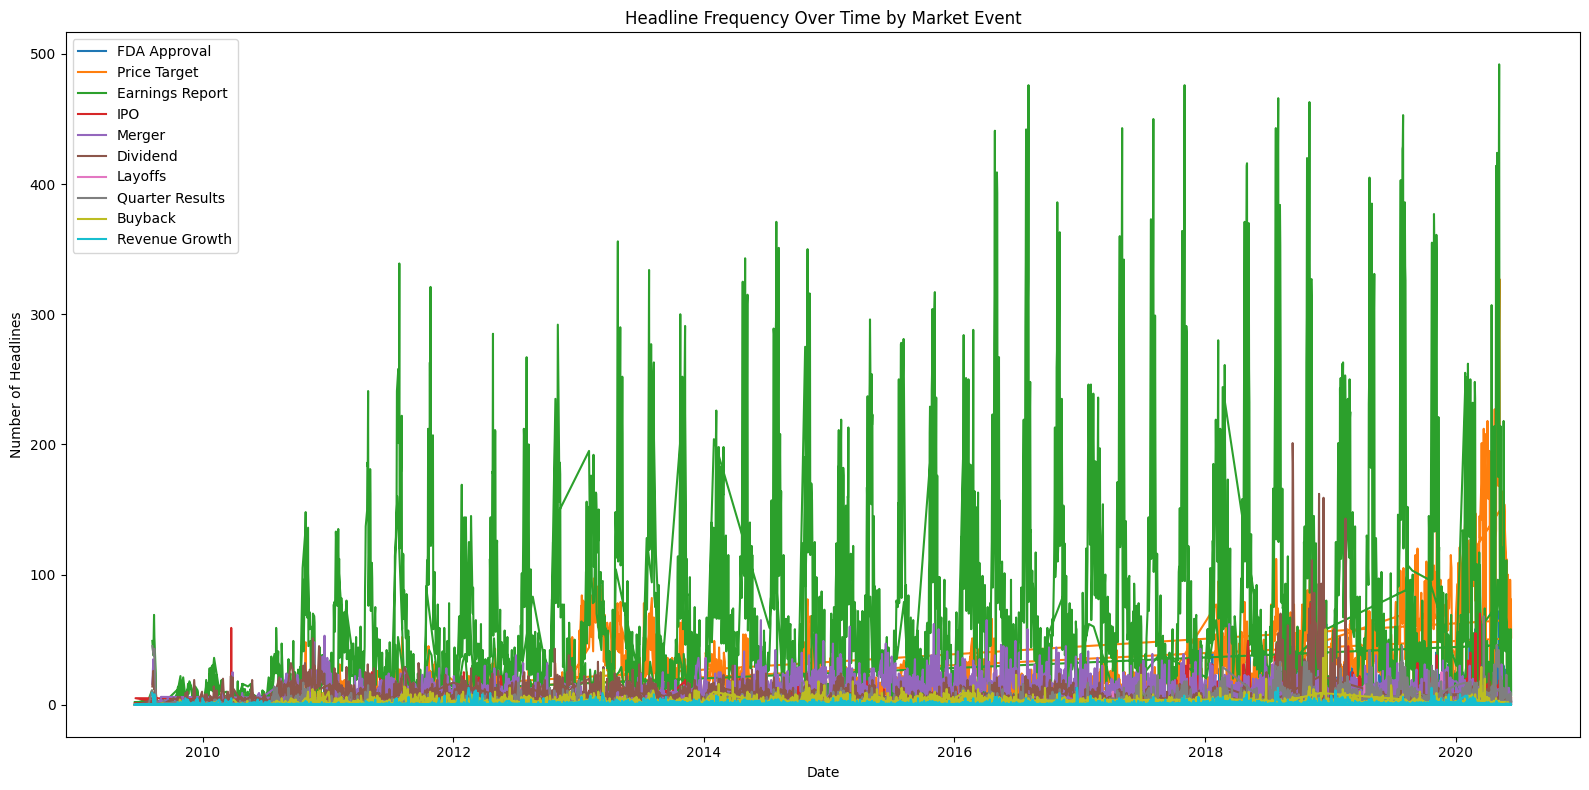

In [ ]:
#plotting spikes with market events
plt.figure(figsize=(16, 8))
for column in topic_counts.columns:
    plt.plot(topic_counts.index, topic_counts[column], label=column)

plt.title("Headline Frequency Over Time by Market Event")
plt.xlabel("Date")
plt.ylabel("Number of Headlines")
plt.legend()
plt.tight_layout()
plt.show()

Text(0.5, 1.0, 'Distribution of Article Publishing Times by Hour')

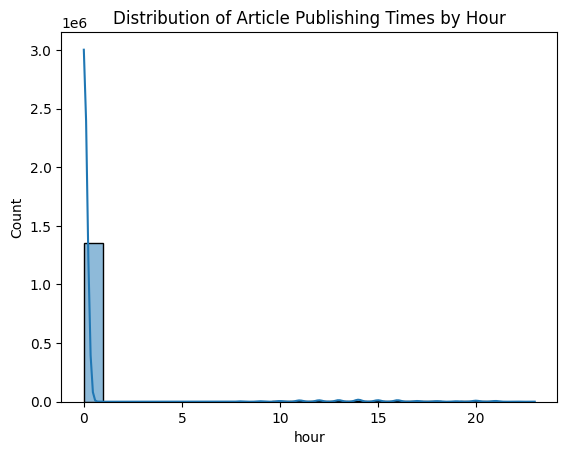

In [28]:
#specific time where news is realeased
df['hour'] = df['date'].dt.hour
sns.histplot(df['hour'], bins=24, kde=True)
plt.title("Distribution of Article Publishing Times by Hour")

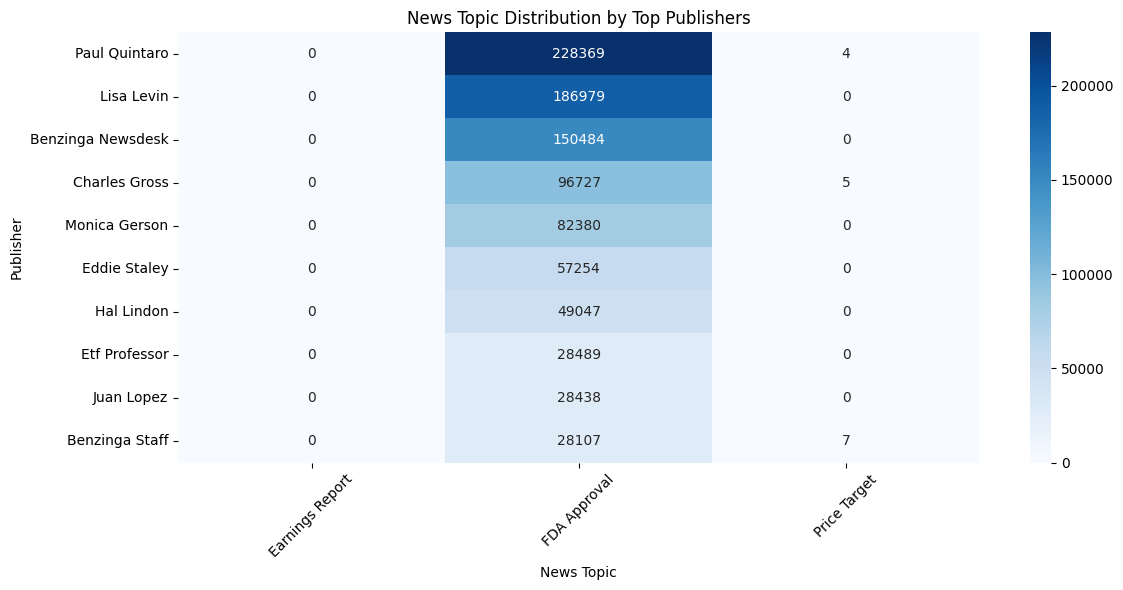

In [34]:
#publisher analysis
def tag_topic(text):
    text = str(text).lower()
    for topic, keywords in topic_keywords.items():
        if any(kw in text for kw in keywords):
            return topic
    return 'Other'

df['topic'] = df['headline'].apply(tag_topic)

topic_distribution = pd.crosstab(df['publisher'], df['topic'])
top_publishers_distribution = topic_distribution.loc[top_publishers.index]
#classify publisher with articles
topic_distribution = pd.crosstab(df['publisher'], df['topic'])
top_publishers_distribution = topic_distribution.loc[top_publishers.index]
#visualize
plt.figure(figsize=(12, 6))
sns.heatmap(top_publishers_distribution, annot=True, fmt='d', cmap='Blues')
plt.title("News Topic Distribution by Top Publishers")
plt.ylabel("Publisher")
plt.xlabel("News Topic")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [36]:
email_publishers = df[df['publisher'].str.contains(r'@', na=False)]
email_publishers = email_publishers.copy()
email_publishers['domain'] = email_publishers['publisher'].str.extract(r'@(.+)$')
domain_counts = email_publishers['domain'].value_counts()
print(domain_counts.head(10))  # Top 10 domains


domain
Benzinga.Com              7937
Gmail.Com                  139
Andyswan.Com                 5
Investdiva.Com               2
Tothetick.Com                2
Eosdetroit.Io                1
Forextraininggroup.Com       1
Stockmetrix.Net              1
Name: count, dtype: int64
